# VQE with Qiskit

This is the current version of my VQE. Ideally this should not be in a Jupyter notebook, of course. But this form is convenient to play with the different parts of the Qiskit's infrastructure and see how they work.

In [57]:
from qiskit import *
import qiskit.tools.jupyter
import numpy as np
IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [58]:
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.components.initial_states import Zero, VarFormBased
from qiskit.aqua.operators import MatrixOperator, TPBGroupedWeightedPauliOperator
from qiskit.aqua.operators.op_converter import to_tpb_grouped_weighted_pauli_operator
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.algorithms.adaptive import VQE

In [59]:
from scipy.sparse import *
from scipy import *

In [4]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.11.1',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.5',
 'qiskit-aqua': '0.6.2',
 'qiskit': '0.14.1'}

In [5]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.11.1',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.5',
 'qiskit-aqua': '0.6.2',
 'qiskit': '0.14.1'}

## VQE Settings

In [6]:
num_qubits = 2

## Variational Form

In [7]:
num_var_params = 3
var_form_depth = 1
optimal_params = [-0.386244, 0.317799, -0.416888] # from exact solution
initial_params = [0.0, 0.0, 0.0]
var_form_depth2 = 2
initial_params2 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # deeper ansatz / layer

In [8]:
class SchwingerAnsatz(VariationalForm):
    """ Variational Layer from Martin's Paper """
    
    CONFIGURATION = {
        'name': 'Schwinger Ansatz',
        'description': 'Variational Form for Schwinger VQE',
        'input_schema': {
            '$schema': 'http://json-schema.org/draft-07/schema#',
            'id': 'schwinger_schema',
            'type': 'object',
            'properties': {
                'depth': {
                    'type': 'integer',
                    'default': 3,
                    'minimum': 1
                },
                'entangler_map': {
                    'type': ['array', 'null'],
                    'default': None
                },
                'entanglement_gate': {
                    'type': 'string',
                    'default': 'cx',
                    'enum': ['cx']
                },
            },
            'additionalProperties': False
        },
        'depends': [
            {
                'pluggable_type': 'initial_state',
                'default': {
                    'name': 'ZERO',
                }
            },
        ],
    }
    
    def __init__(self, depth=3, entangler_map=None, initial_state=None):
        """
        Constructor.
        Args:
            depth (int) : number of rotation layers
            entangler_map (list[list]): describe the connectivity of qubits, each list describes
                             [source, target], or None for full entanglement.
                             Note that the order is the list is the order of
                             applying the two-qubit gate.
            initial_state (InitialState): an initial state object
        """
        self.validate(locals())
        super().__init__()
        #_support_parameterized_circuit = True
        # hard-coded, first pass through FIXME
        num_qubits = 2
        num_parameters = 3
        entanglement='full'
        entanglement_gate='cx'
        skip_unentangled_qubits = False
        self._num_qubits = num_qubits 
        self._depth = depth
        if entangler_map is None:
            self._entangler_map = VariationalForm.get_entangler_map(entanglement, num_qubits)
        else:
            self._entangler_map = VariationalForm.validate_entangler_map(entangler_map, num_qubits)
        # determine the entangled qubits
        all_qubits = []
        for src, targ in self._entangler_map:
            all_qubits.extend([src, targ])
        self._entangled_qubits = sorted(list(set(all_qubits)))
        self._initial_state = initial_state
        self._entanglement_gate = entanglement_gate
        self._skip_unentangled_qubits = skip_unentangled_qubits
        # for the first layer
        self._num_parameters = num_parameters
        # for repeated block
        self._num_parameters += num_parameters * (depth-1)
        self._bounds = [(-np.pi, np.pi)] * self._num_parameters
    
    def construct_circuit(self, parameters, q=None):
        """
        Construct the variational form, given its parameters.
        
        Args:
            parameters (numpy.ndarray): circuit parameters
            q (QuantumRegister): Quantum Register for the circuit.
            
        Returns:
            QuantumCircuit: a quantum circuit with given `parameters`
            
        Raises:
            ValueError: the number of parameters is incorrect.
        """
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))
        
        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        #
        param_idx = 0
        
        def angle(theta=0., phi=0., lam=0.):
            return [theta, phi, lam]

        for _ in range(self._depth):
            # get variational parameters for this layer
            t0 = parameters[param_idx] # theta-angle values
            t1 = parameters[param_idx+1]
            t2 = parameters[param_idx+2]
            t = [angle(t_i) for t_i in [t0, t1, t2]]
            # Construct circuit
            circuit.u3(*(t[1]), 0)  # u3(*angles, q)
            circuit.u3(*(t[0]), 1)
            circuit.cx(0, 1)        # entangling qubit cx(ctrl, tgt)
            circuit.u3(*(t[0]), 1)
            circuit.cx(0, 1)        # entangling qubit cx(ctrl, tgt)
            circuit.u3(*(t[2]), 1)
            circuit.barrier(q)

        return circuit  

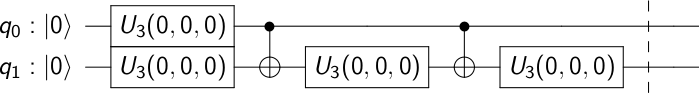

In [9]:
schwinger_form = SchwingerAnsatz(var_form_depth)
vqs_circ = schwinger_form.construct_circuit(initial_params)
vqs_circ.draw(output='latex', scale=0.5)

## Initial State

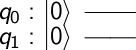

In [10]:
fiducial_state = Zero(num_qubits)
fid_circ = fiducial_state.construct_circuit()
fid_circ.draw(output='latex', scale=0.5)

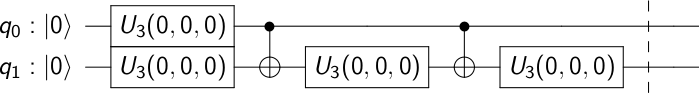

In [11]:
var_form_wavefunction = VarFormBased(schwinger_form, initial_params)
var_form_wavefunction.construct_circuit().draw(output='latex', scale=0.5)

## Hamiltonian

In [12]:
# these correspond to L=2 spatial sites. 
# They have slightly different truncations so that the dimensions of the matrices are the same.

h_even = np.array([
 [-0.20036, 1.19976, 0., 0.],
 [1.19976, 1., 0.848358, 0.],
 [0., 0.848358, 2.20036, 0.848358],
 [0., 0., 0.848358, 3.]
])

h_odd = np.array([
    [1., 0.848358, 0., 0.],
    [0.848358, 2.20036, -0.848358, 0.],
    [0., -0.848358, 3., -0.848358],
    [0., 0., -0.848358, 3.79964]
])

In [13]:
# this is a "switch" :)
h = h_even
# h = h_odd

In [14]:
# Thread on qubit ordering in Qiskit
# https://github.com/Qiskit/qiskit-terra/issues/1148

In [15]:
H_mat = csr_matrix(h)
H_MatrixOperator = MatrixOperator(H_mat)
H_Operator = to_tpb_grouped_weighted_pauli_operator(H_MatrixOperator, 
                                                    TPBGroupedWeightedPauliOperator.sorted_grouping)
print(H_Operator.print_details())

TPB: YY (2)
II	(1.5+0j)
YY	(0.424179+0j)
TPB: XX (2)
IX	(1.0240589999999998+0j)
XX	(0.424179+0j)
TPB: ZZ (3)
IZ	(-0.5+0j)
ZI	(-1.10018+0j)
ZZ	(-0.10017999999999999+0j)
TPB: ZX (1)
ZX	(0.175701+0j)



In [16]:
operator_mode=None
input_circuit=var_form_wavefunction.construct_circuit()
backend=None
qr=None
cr=None
use_simulator_operator_mode=False
use_simulator_snapshot_mode=False
wave_function=fid_circ
statevector_mode=False

In [67]:
input_circuit.draw()

In [17]:
H_circs = H_Operator.construct_evaluation_circuit(input_circuit, # wavefunction
                                        statevector_mode,
                                        qr,
                                        cr,
                                        use_simulator_snapshot_mode)

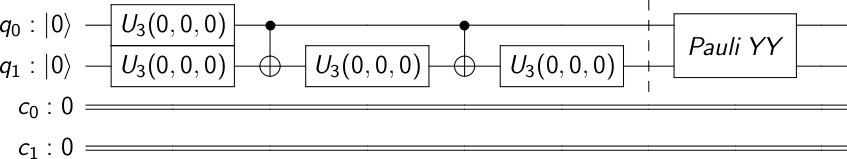

In [18]:
H_circs[0].draw(output='latex', scale=0.5)

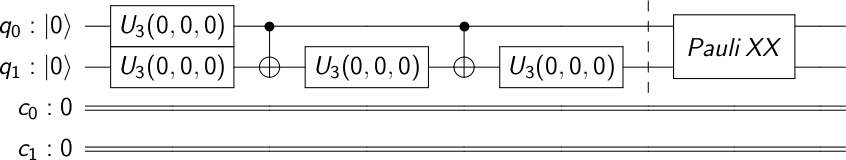

In [19]:
H_circs[1].draw(output='latex', scale=0.5)

## Optimizer

In [20]:
max_trials = 500
optimizer = qiskit.aqua.components.optimizers.SPSA(max_trials)
print(optimizer.setting) 

Optimizer: SPSA
-- gradient_support_level: 1
-- bounds_support_level: 1
-- initial_point_support_level: 3
-- options: {'last_avg': 1, 'save_steps': 1}
-- max_evals_grouped: 1
-- max_trials: 500
-- parameters: [0.62831853 0.1        0.602      0.101      0.        ]
-- skip_calibration: False



## Variational Quantum Simulation
### Extend VQE class to incude statistics in results, or find a way to retrieve statistics from the existing class

Q: where is the counts object in the existing class?

In [21]:
# a callback that can access the intermediate data 
# during the optimization.
# Internally, four arguments are provided as follows 
# the index of evaluation, parameters of variational form,
# evaluated mean, evaluated standard deviation.
def simple_callback(eval_count, parameter_set, mean, std):
    if eval_count % 1 == 0:
        print('Energy evaluation %s returned %4f +/- %4f' % (eval_count, np.real(mean), np.real(std)))

In [22]:
# classVQE(operator, var_form, optimizer, 
# operator_mode=None, initial_point=None, 
# max_evals_grouped=1, 
# aux_operators=None, callback=None, 
# auto_conversion=True)
operator_mode = None
initial_point = initial_params
max_evals_grouped=1              # max number of evaluations performed simultaneously
aux_operators = None
auto_conversion=False
sim = VQE(H_Operator, schwinger_form, optimizer,
          # operator_mode, not needed in the most recent version
          initial_point, 
          max_evals_grouped, 
          aux_operators, 
          simple_callback, 
          auto_conversion)

In [23]:
backend = None
use_simulator_operator_mode=False
# is backend from AerProvider,
# if True and mode is paulis, single circuit is generated.
use_simulator_snapshot_mode=True
statevector_mode=False

In [24]:
sim_circs = sim.construct_circuit(initial_params, 
                                  statevector_mode,
                                  use_simulator_snapshot_mode)

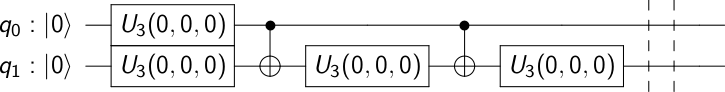

In [25]:
sim_circs[0].draw(output='latex', scale=0.5)

In [60]:
# backend_sim = Aer.get_backend('qasm_simulator')
# qasm_simulator
provider = IBMQ.get_provider(group="open")

In [61]:
backend_sim = provider.get_backend('ibmq_5_yorktown')

In [62]:
print(backend_sim)

ibmqx2


In [63]:
from qiskit.aqua import QuantumInstance
nshots = 1024
my_quantum_instance = QuantumInstance(backend_sim, nshots)

The skip Qobj validation does not work for IBMQ provider. Disable it.


In [64]:
print(my_quantum_instance)


Qiskit Terra version: 0.11.1
Backend: 'ibmqx2 (<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id'], 'coupling_map': [[0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 3], [2, 4], [3, 2], [3, 4], [4, 2], [4, 3]]}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1024)
{'timeout': None, 'wait': 5}
{}
{}
Measurement mitigation: None


In [65]:
print(sim.print_settings())


==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: 
Qiskit Terra version: 0.11.1
Backend: 'qasm_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, memory=False, shots=8192)
{'timeout': None}
{}
{}
Measurement mitigation: None
-- var_form: <__main__.SchwingerAnsatz object at 0x12c361ef0>
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x12e1b2e80>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x12e1b2940>>
-- initial_point: [0.0, 0.0, 0.0]
-- parameterized_ci

In [66]:
res = sim.run(my_quantum_instance)

Energy evaluation 1 returned 0.032381 +/- 0.044072
Energy evaluation 2 returned -0.100926 +/- 0.040922
Energy evaluation 3 returned -0.044958 +/- 0.040293
Energy evaluation 4 returned 0.206285 +/- 0.046577
Energy evaluation 5 returned -0.106519 +/- 0.042933
Energy evaluation 6 returned 0.066414 +/- 0.041238
Energy evaluation 7 returned 0.036641 +/- 0.038699
Energy evaluation 8 returned -0.056584 +/- 0.045626
Energy evaluation 9 returned -0.103065 +/- 0.042733
Energy evaluation 10 returned 0.102217 +/- 0.040802
Energy evaluation 11 returned 0.133430 +/- 0.043352
Energy evaluation 12 returned -0.139119 +/- 0.040341
Energy evaluation 13 returned -0.070321 +/- 0.041055
Energy evaluation 14 returned 0.121324 +/- 0.043383
Energy evaluation 15 returned 0.059106 +/- 0.040975
Energy evaluation 16 returned -0.087668 +/- 0.042869
Energy evaluation 17 returned -0.136300 +/- 0.041277
Energy evaluation 18 returned 0.096434 +/- 0.042595
Energy evaluation 19 returned 0.011388 +/- 0.046799
Energy evalu

Energy evaluation 156 returned -0.680917 +/- 0.038711
Energy evaluation 157 returned -0.748757 +/- 0.038936
Energy evaluation 158 returned -0.815832 +/- 0.034119
Energy evaluation 159 returned -0.722251 +/- 0.039472
Energy evaluation 160 returned -0.694896 +/- 0.033746
Energy evaluation 161 returned -0.744663 +/- 0.037546
Energy evaluation 162 returned -0.699717 +/- 0.035191
Energy evaluation 163 returned -0.748107 +/- 0.037936
Energy evaluation 164 returned -0.748397 +/- 0.036202
Energy evaluation 165 returned -0.743495 +/- 0.034176
Energy evaluation 166 returned -0.762062 +/- 0.039260
Energy evaluation 167 returned -0.840664 +/- 0.033346
Energy evaluation 168 returned -0.722985 +/- 0.040136
Energy evaluation 169 returned -0.810749 +/- 0.036403
Energy evaluation 170 returned -0.766306 +/- 0.034607
Energy evaluation 171 returned -0.834441 +/- 0.034459
Energy evaluation 172 returned -0.769758 +/- 0.034279
Energy evaluation 173 returned -0.774231 +/- 0.033856
Energy evaluation 174 return

Energy evaluation 308 returned -0.732035 +/- 0.035237
Energy evaluation 309 returned -0.749292 +/- 0.039386
Energy evaluation 310 returned -0.770819 +/- 0.035055
Energy evaluation 311 returned -0.683766 +/- 0.037844
Energy evaluation 312 returned -0.773348 +/- 0.036610
Energy evaluation 313 returned -0.786205 +/- 0.037008
Energy evaluation 314 returned -0.763149 +/- 0.036815
Energy evaluation 315 returned -0.791293 +/- 0.035605
Energy evaluation 316 returned -0.757566 +/- 0.037991
Energy evaluation 317 returned -0.781920 +/- 0.034718
Energy evaluation 318 returned -0.803094 +/- 0.037941
Energy evaluation 319 returned -0.745379 +/- 0.037946
Energy evaluation 320 returned -0.761852 +/- 0.035051
Energy evaluation 321 returned -0.770068 +/- 0.037425
Energy evaluation 322 returned -0.770800 +/- 0.034911
Energy evaluation 323 returned -0.728968 +/- 0.038700
Energy evaluation 324 returned -0.742993 +/- 0.034742
Energy evaluation 325 returned -0.744824 +/- 0.037822
Energy evaluation 326 return

Energy evaluation 460 returned -0.780877 +/- 0.035858
Energy evaluation 461 returned -0.760886 +/- 0.037803
Energy evaluation 462 returned -0.817227 +/- 0.034340
Energy evaluation 463 returned -0.793691 +/- 0.036763
Energy evaluation 464 returned -0.681610 +/- 0.035502
Energy evaluation 465 returned -0.732541 +/- 0.037813
Energy evaluation 466 returned -0.790724 +/- 0.034997
Energy evaluation 467 returned -0.775543 +/- 0.035516
Energy evaluation 468 returned -0.709463 +/- 0.037432
Energy evaluation 469 returned -0.792418 +/- 0.035044
Energy evaluation 470 returned -0.748458 +/- 0.036715
Energy evaluation 471 returned -0.739997 +/- 0.033707
Energy evaluation 472 returned -0.753574 +/- 0.038280
Energy evaluation 473 returned -0.756903 +/- 0.036333
Energy evaluation 474 returned -0.682731 +/- 0.037133
Energy evaluation 475 returned -0.708564 +/- 0.036757
Energy evaluation 476 returned -0.710636 +/- 0.037473
Energy evaluation 477 returned -0.759272 +/- 0.034754
Energy evaluation 478 return

Energy evaluation 612 returned -0.722476 +/- 0.035704
Energy evaluation 613 returned -0.769072 +/- 0.035726
Energy evaluation 614 returned -0.813075 +/- 0.033458
Energy evaluation 615 returned -0.756188 +/- 0.033929
Energy evaluation 616 returned -0.786416 +/- 0.035454
Energy evaluation 617 returned -0.697554 +/- 0.033485
Energy evaluation 618 returned -0.813268 +/- 0.035886
Energy evaluation 619 returned -0.768572 +/- 0.035394
Energy evaluation 620 returned -0.781765 +/- 0.035785
Energy evaluation 621 returned -0.738449 +/- 0.034013
Energy evaluation 622 returned -0.785912 +/- 0.037491
Energy evaluation 623 returned -0.747962 +/- 0.036564
Energy evaluation 624 returned -0.810583 +/- 0.035520
Energy evaluation 625 returned -0.806985 +/- 0.032536
Energy evaluation 626 returned -0.716514 +/- 0.038787
Energy evaluation 627 returned -0.773018 +/- 0.033947
Energy evaluation 628 returned -0.770981 +/- 0.037195
Energy evaluation 629 returned -0.777155 +/- 0.036186
Energy evaluation 630 return

FAILURE: job id: 5e362cef09cad5001857fac7, status: 'FAIL_TO_GET_STATUS' Terra job error: '"HTTPSConnectionPool(host=\'api.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q/Groups/open/Projects/main/Jobs/5e362cef09cad5001857fac7/status (Caused by NewConnectionError(\'<urllib3.connection.VerifiedHTTPSConnection object at 0x1324f2ef0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\',))"'


Energy evaluation 702 returned -0.778591 +/- 0.036960
Energy evaluation 703 returned -0.711990 +/- 0.036936
Energy evaluation 704 returned -0.724296 +/- 0.033032
Energy evaluation 705 returned -0.746744 +/- 0.038529
Energy evaluation 706 returned -0.724685 +/- 0.033254
Energy evaluation 707 returned -0.776120 +/- 0.038309
Energy evaluation 708 returned -0.820981 +/- 0.032245
Energy evaluation 709 returned -0.753887 +/- 0.034745
Energy evaluation 710 returned -0.833277 +/- 0.034619
Energy evaluation 711 returned -0.706697 +/- 0.036531
Energy evaluation 712 returned -0.792527 +/- 0.034134
Energy evaluation 713 returned -0.806514 +/- 0.035163
Energy evaluation 714 returned -0.815250 +/- 0.035236
Energy evaluation 715 returned -0.822883 +/- 0.034713
Energy evaluation 716 returned -0.790932 +/- 0.033842
Energy evaluation 717 returned -0.738124 +/- 0.034712
Energy evaluation 718 returned -0.806320 +/- 0.035224
Energy evaluation 719 returned -0.737009 +/- 0.034190
Energy evaluation 720 return

Energy evaluation 854 returned -0.768332 +/- 0.034586
Energy evaluation 855 returned -0.754864 +/- 0.034476
Energy evaluation 856 returned -0.792201 +/- 0.036312
Energy evaluation 857 returned -0.732692 +/- 0.033929
Energy evaluation 858 returned -0.767906 +/- 0.036193
Energy evaluation 859 returned -0.787913 +/- 0.033443
Energy evaluation 860 returned -0.776091 +/- 0.038226
Energy evaluation 861 returned -0.707349 +/- 0.033905
Energy evaluation 862 returned -0.714081 +/- 0.037935
Energy evaluation 863 returned -0.720205 +/- 0.036198
Energy evaluation 864 returned -0.840149 +/- 0.033405
Energy evaluation 865 returned -0.791214 +/- 0.033896
Energy evaluation 866 returned -0.723313 +/- 0.037161
Energy evaluation 867 returned -0.726623 +/- 0.035987
Energy evaluation 868 returned -0.745297 +/- 0.037197
Energy evaluation 869 returned -0.741967 +/- 0.034236
Energy evaluation 870 returned -0.761832 +/- 0.037025
Energy evaluation 871 returned -0.740591 +/- 0.034134
Energy evaluation 872 return

Energy evaluation 1006 returned -0.723787 +/- 0.036126
Energy evaluation 1007 returned -0.730821 +/- 0.038114
Energy evaluation 1008 returned -0.768083 +/- 0.035740
Energy evaluation 1009 returned -0.697879 +/- 0.037358
Energy evaluation 1010 returned -0.771851 +/- 0.035452
Energy evaluation 1011 returned -0.785275 +/- 0.034970


FAILURE: job id: 5e36574444cb3d0018179559, status: 'FAIL_TO_GET_STATUS' Terra job error: "'501 Server Error: Not Implemented for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/5e36574444cb3d0018179559/status'"
FAILURE: job id: 5e36574444cb3d0018179559, status: 'FAIL_TO_GET_STATUS' Terra job error: "'501 Server Error: Not Implemented for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/5e36574444cb3d0018179559/status'"


Energy evaluation 1012 returned -0.784913 +/- 0.037101
Energy evaluation 1013 returned -0.752569 +/- 0.037765
Energy evaluation 1014 returned -0.722532 +/- 0.034557
Energy evaluation 1015 returned -0.712719 +/- 0.036692
Energy evaluation 1016 returned -0.756421 +/- 0.035947
Energy evaluation 1017 returned -0.820097 +/- 0.036934
Energy evaluation 1018 returned -0.771999 +/- 0.034725
Energy evaluation 1019 returned -0.657963 +/- 0.038256
Energy evaluation 1020 returned -0.753820 +/- 0.035548
Energy evaluation 1021 returned -0.788623 +/- 0.035991
Energy evaluation 1022 returned -0.809930 +/- 0.035126
Energy evaluation 1023 returned -0.772810 +/- 0.036165
Energy evaluation 1024 returned -0.797007 +/- 0.035721
Energy evaluation 1025 returned -0.743444 +/- 0.037564
Energy evaluation 1026 returned -0.760850 +/- 0.034492
Energy evaluation 1027 returned -0.733236 +/- 0.034196
Energy evaluation 1028 returned -0.730195 +/- 0.037955
Energy evaluation 1029 returned -0.753329 +/- 0.038215
Energy eva

In [68]:
res

{'num_optimizer_evals': None,
 'min_val': -0.7717770898437497,
 'opt_params': array([ 0.19542627, -1.17248482,  0.01695746]),
 'eval_time': 35248.37902903557,
 'eval_count': 1051,
 'energy': -0.7717770898437497,
 'eigvals': array([-0.77177709]),
 'min_vector': {'01': 322, '10': 37, '00': 632, '11': 33},
 'eigvecs': array([{'01': 322, '10': 37, '00': 632, '11': 33}], dtype=object)}

In [69]:
sim.get_optimal_vector()

{'01': 306, '10': 56, '00': 633, '11': 29}

In [70]:
sim.get_optimal_cost()

-0.7717770898437497

In [71]:
energy_eval = sim.get_optimal_cost()

In [72]:
energy_eval_err = 0.011

In [73]:
sim._ret['opt_params']

array([ 0.19542627, -1.17248482,  0.01695746])

In [74]:
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])

Energy evaluation 1052 returned -0.774006 +/- 0.036572
Energy evaluation 1053 returned -0.834709 +/- 0.035706
Energy evaluation 1054 returned -0.730064 +/- 0.037173
Energy evaluation 1055 returned -0.772066 +/- 0.036642
Energy evaluation 1056 returned -0.726406 +/- 0.037241


-0.7264059921874997

In [75]:
sim.quantum_instance.backend

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

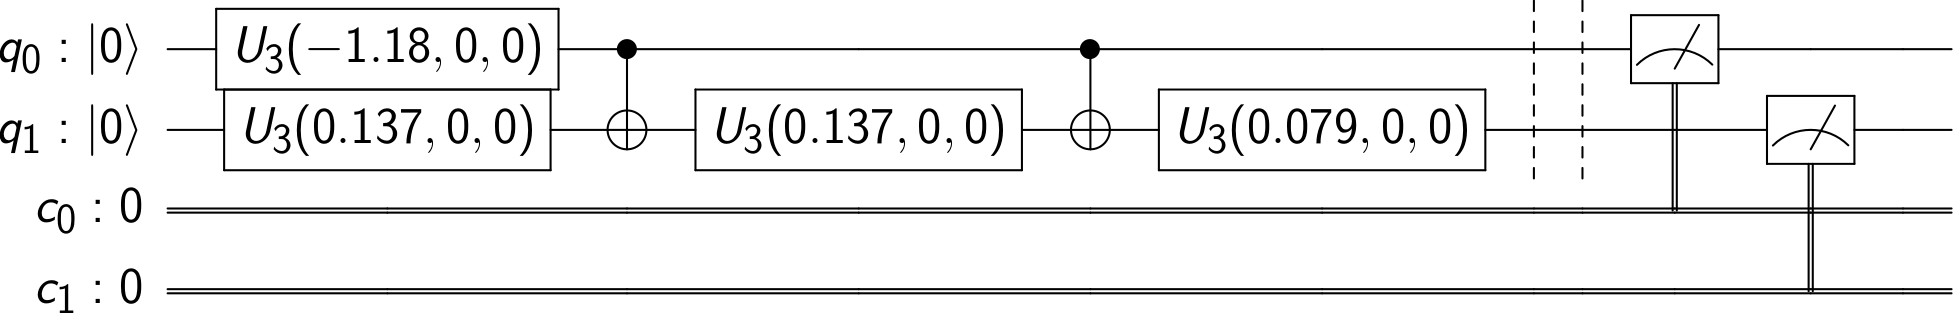

In [39]:
from qiskit.aqua.utils.run_circuits import find_regs_by_name
opt_circ = sim.get_optimal_circuit()
c = ClassicalRegister(opt_circ.width(), name='c')
q = find_regs_by_name(opt_circ, 'q')
opt_circ.add_register(c)
opt_circ.barrier(q)
opt_circ.measure(q, c)
opt_circ.draw(output='latex', filename='example_gate.png', scale=1.0)

In [40]:
latex_source = opt_circ.draw(output='latex_source', filename='example_gate.png', scale=0.5)
print(latex_source)

% \documentclass[preview]{standalone}
% If the image is too large to fit on this documentclass use
\documentclass[draft]{beamer}
% img_width = 4, img_depth = 11
\usepackage[size=custom,height=10,width=39,scale=0.5]{beamerposter}
% instead and customize the height and width (in cm) to fit.
% Large images may run out of memory quickly.
% To fix this use the LuaLaTeX compiler, which dynamically
% allocates memory.
\usepackage[braket, qm]{qcircuit}
\usepackage{amsmath}
\pdfmapfile{+sansmathaccent.map}
% \usepackage[landscape]{geometry}
% Comment out the above line if using the beamer documentclass.
\begin{document}
\begin{equation*}
    \Qcircuit @C=1.0em @R=0.0em @!R {
	 	\lstick{ q_{0} : \ket{0} } & \gate{U_3(-1.18,0,0)} & \ctrl{1} & \qw & \ctrl{1} & \qw \barrier[0em]{1} & \qw \barrier[0em]{1} & \qw & \meter & \qw & \qw & \qw\\
	 	\lstick{ q_{1} : \ket{0} } & \gate{U_3(0.137,0,0)} & \targ & \gate{U_3(0.137,0,0)} & \targ & \gate{U_3(0.079,0,0)} & \qw & \qw & \qw & \meter & \qw & \qw\\
	 	

In [41]:
# build an optimized circuit;
# make measurement, retrieve memory
# bootstrap uncertainties

In [76]:
sim.quantum_instance.run_config.shots

1024

In [77]:
sim.quantum_instance.set_config(shots=1024, memory=True)

In [78]:
sim.quantum_instance.run_config

RunConfig(max_credits=10, memory=True, shots=1024)

In [79]:
# takes in results from a single circuit 
# with memory=True, and estimates
# the uncertanities on the probability of each outcome 
# (currently with bootstrap)
# returns outcome:(pba, std) dictionary
def compute_stats(res, invert_qubit_order = False):
    # check that there is a single circuit in the results
    # (ambiguous otherwise)
    assert(len(res.results)==1)
    # generates all possible outcomes given \
    # the number of qubits 
    def _generate_bitstrings(nqubits, invert_qubit_order):
        # (recursive, modifies all_strings in place)
        def _generate_bitstrings_rec(nqubits, all_strings, a_string, irecur): 
            # base
            if irecur == nqubits: 
                all_strings.append(''.join([bit for bit in a_string]))
                return 
            # append 0
            _generate_bitstrings_rec(nqubits, all_strings, a_string + ['0'], irecur + 1)
            # append 1
            _generate_bitstrings_rec(nqubits, all_strings, a_string + ['1'], irecur + 1)
        all_strings = []
        _generate_bitstrings_rec(nqubits, all_strings, [], 0)
        if (invert_qubit_order): 
        # pesky Qiskit messes up qubit ordering... this may or may not be necessary to translate the results.
            all_strings = [''.join(reversed(bitstring)) for bitstring in all_strings]
        return all_strings
    # bootstrap specific?
    # given ensembles of outcomes and a particular outcome
    # calculates the statistics of that outcome:
    # returns outcome:(pba, std) estimates for the outcome
    def _calc_outcome_stats(ensembles, nshots, outcome):
        cts = np.count_nonzero(ensembles==outcome, axis=0)
        pba = np.mean(cts)/nshots
        std = np.std(cts/nshots, ddof = 1) # use unbiased estimator
        return (pba, std)
    nqubits = int(np.log2(len(res.get_counts(0)))) # pull number of qubits from results
    outcomes = _generate_bitstrings(nqubits, invert_qubit_order)
    mem = res.get_memory(0)
    nshots = sum(list(res.get_counts(0).values()))
    nens = nshots # choose number of ensemles = number of samples
    nsam = nshots
    ensembles = np.random.choice(mem, (nens, nsam))
    stats = map(lambda outcome: (outcome, _calc_outcome_stats(ensembles, nshots, outcome)), outcomes)
    return dict(stats)

In [84]:
sim.quantum_instance.set_config(shots=1024, memory=True)
opt_res = sim.quantum_instance.execute(opt_circ)
sim.quantum_instance.set_config(shots=1024, memory=False) # reset to no memory! saves resources?

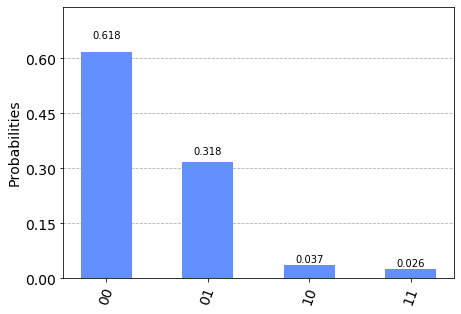

In [85]:
from qiskit.visualization import plot_histogram
plot_histogram(opt_res.get_counts(opt_circ))

In [86]:
measured_coeffs =compute_stats(opt_res, False)

In [87]:
measured_coeffs

{'00': (0.617706298828125, 0.014986103888819274),
 '01': (0.31874656677246094, 0.014887180954741418),
 '10': (0.037270545959472656, 0.006089766856725273),
 '11': (0.026276588439941406, 0.00476308672585744)}

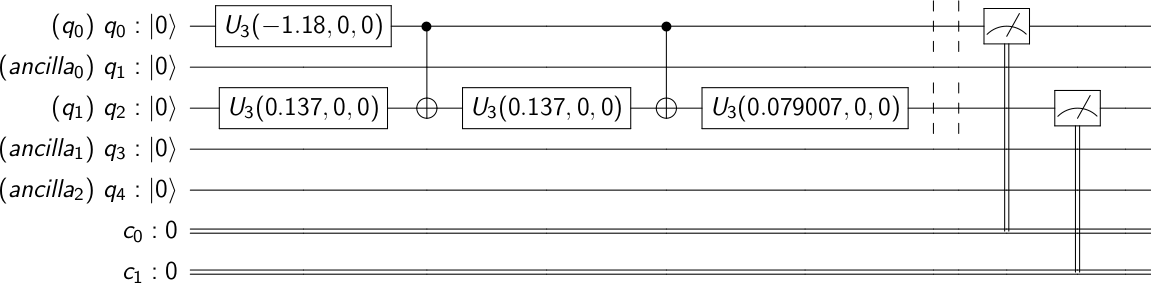

In [88]:
transp_circ = transpile(opt_circ, sim.quantum_instance.backend, optimization_level=3)
transp_circ.draw(output='latex', scale=0.5)

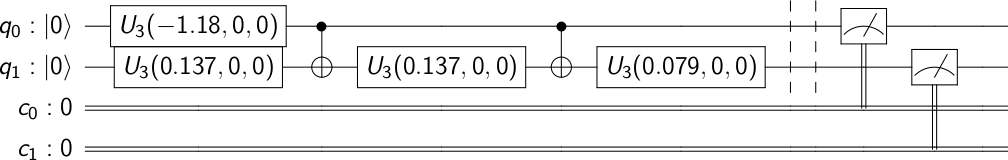

In [51]:
opt_circ.decompose().draw(output='latex', scale=0.5)

In [110]:
# compare with Mathematica's expectations
mathematica_res = -1.01162 # Even
mathematica_res2 = 0.486204 # Odd

# odd coefficients
even_coeffs = [0.669069, 0.305919, 0.023941, 0.00107068]
even_coeffs_at_theta = [0.664109, 0.309821, 0.0236388, 0.00243079]
odd_coeffs = [0.7041621406145364, 0.2582831083289985, 0.03524433188695736, 0.002310419169507747]

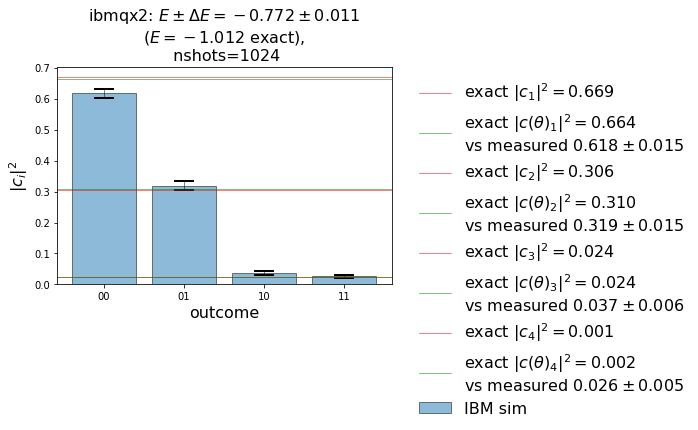

In [114]:
import matplotlib.pyplot as plt
outcomes = list(measured_coeffs.keys())
outcomes_bars = np.arange(len(outcomes))
avgs = [measured_coeffs[outcome][0] for outcome in outcomes]
stds = [measured_coeffs[outcome][1] for outcome in outcomes]
fig, ax = plt.subplots()
ax.bar(outcomes_bars, avgs, yerr=stds, 
       align='center', alpha=0.5, ecolor='black',
       edgecolor='k',
       error_kw=dict(lw=0.5, capsize=10, capthick=2.0),
       label='IBM sim')
ax.set_ylabel(r'$|c_i|^2$', fontsize=16)
ax.set_xlabel(r'outcome', fontsize=16)
ax.set_xticks(outcomes_bars)
ax.set_xticklabels(outcomes)
ax.set_title('ibmqx2: $E \\pm \\Delta E = %.3f \\pm %.3f$\n($E = %.3f$ exact),\n nshots=%d' 
             % (energy_eval, energy_eval_err, mathematica_res, 
                sim.quantum_instance.run_config.shots), fontsize=16)
for icoeff in range(len(even_coeffs)):
    ax.axhline(y = even_coeffs[icoeff], color ='red', linewidth = 0.5, 
               label=r'exact $|c_{%d}|^2 = %.3f$' % (icoeff+1, even_coeffs[icoeff]))
    ax.axhline(y = even_coeffs_at_theta[icoeff], color ='green', linewidth = 0.5, 
               label=r'exact $|c(\theta)_{%d}|^2 = %.3f$''\n'r'vs measured $%.3f \pm %.3f$' % (icoeff+1, even_coeffs_at_theta[icoeff], *list(measured_coeffs.values())[icoeff]))
# ax.set_yscale('log')
# plt.tight_layout()
plt.legend(frameon=False, fontsize=16, bbox_to_anchor=(1.04,1), loc="upper left")
# plt.savefig("ibmqx2_log.png", dpi=300)

In [54]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.11.1',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.5',
 'qiskit-aqua': '0.6.2',
 'qiskit': '0.14.1'}

In [101]:
measured_coeffs

{'00': (0.617706298828125, 0.014986103888819274),
 '01': (0.31874656677246094, 0.014887180954741418),
 '10': (0.037270545959472656, 0.006089766856725273),
 '11': (0.026276588439941406, 0.00476308672585744)}

In [102]:
list(measured_coeffs.values())

[(0.617706298828125, 0.014986103888819274),
 (0.31874656677246094, 0.014887180954741418),
 (0.037270545959472656, 0.006089766856725273),
 (0.026276588439941406, 0.00476308672585744)]

In [104]:
list(measured_coeffs.values())[1]

(0.31874656677246094, 0.014887180954741418)